In [1]:
# Load required libraries
library(tidyverse)
library(janitor)
library(dplyr)
library(ggplot2)
library(skimr)
library(purrr)
library(lubridate)

# Source helper scripts
source("../../R/apply_factors.R")
source("../../R/analysis_helpers.R")
source("../../R/temporal_helpers.R")

# Load data
tables <- list(
  Orders  = readr::read_csv("../../data/processed/Orders.csv"),
  Returns = readr::read_csv("../../data/processed/Returns.csv"),
  People  = readr::read_csv("../../data/processed/People.csv")
)

# Apply factor transformations
tables <- apply_factors(tables)

# Extract tables
orders  <- tables$Orders
returns <- tables$Returns
people  <- tables$People

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Rows: 51290 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (13): order_id, ship_mode, customer_name, segment, state, country, mark...
dbl   (6): sales, quantity, discount, profit, shipping_cost, year
date  (2): order_date, ship_date

ℹ Use `spec()` to retrieve the full column specification f

# Executive Overview (Segment-Level)

### Total Sales by Segment

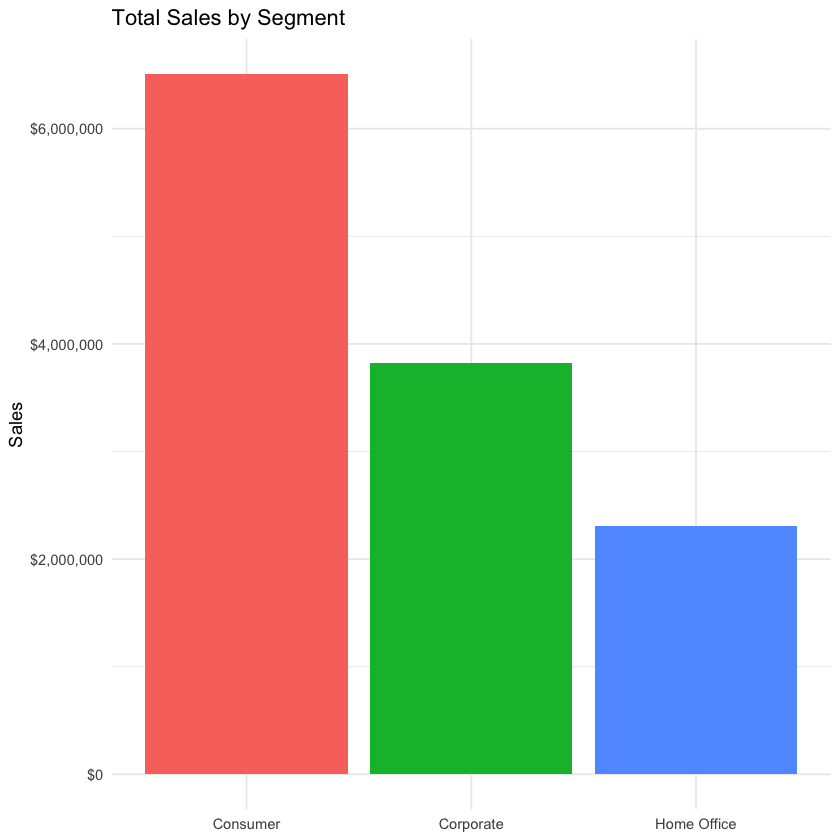

In [3]:
orders |> 
    group_by(segment) |> 
    summarise(total_sales = sum(sales)) |> 
    ggplot(aes(segment, total_sales, fill = segment)) + 
    geom_col() + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Total Sales by Segment", 
        x = NULL, 
        y = "Sales"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

### Total Profit by Segment

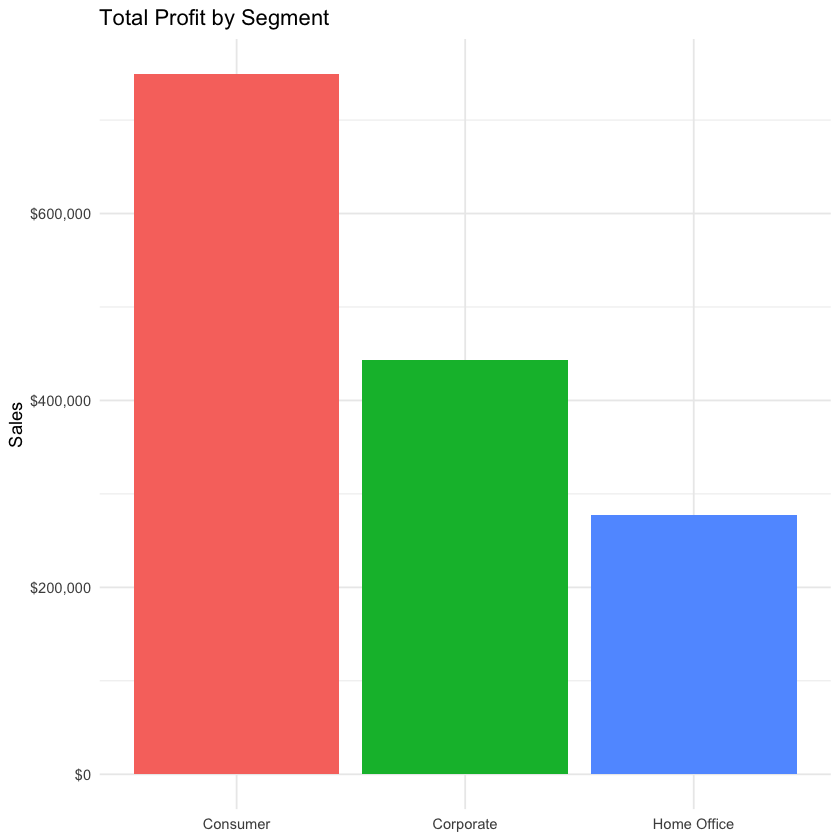

In [4]:
orders |> 
    group_by(segment) |> 
    summarise(total_profit = sum(profit)) |> 
    ggplot(aes(segment, total_profit, fill = segment)) + 
    geom_col() + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Total Profit by Segment", 
        x = NULL, 
        y = "Sales"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

### Profit Margin by Segment

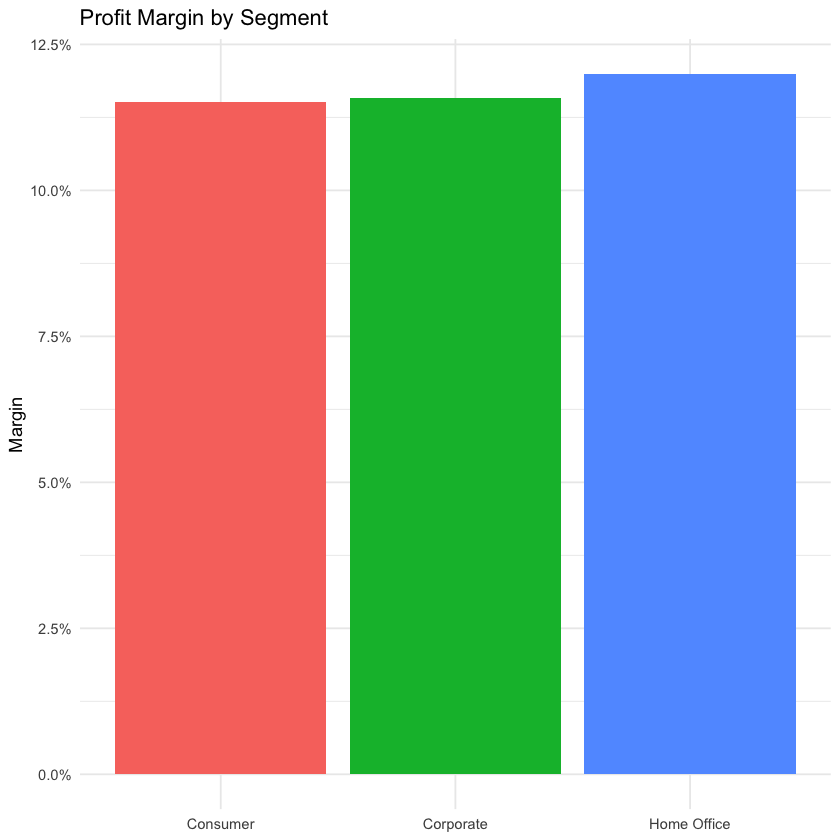

In [5]:
orders |> 
    group_by(segment) |> 
    summarise(margin = sum(profit) / sum(sales)) |> 
    ggplot(aes(segment, margin, fill = segment)) + 
    geom_col() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Profit Margin by Segment", 
        x = NULL, 
        y = "Margin"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

### Orders by Segment

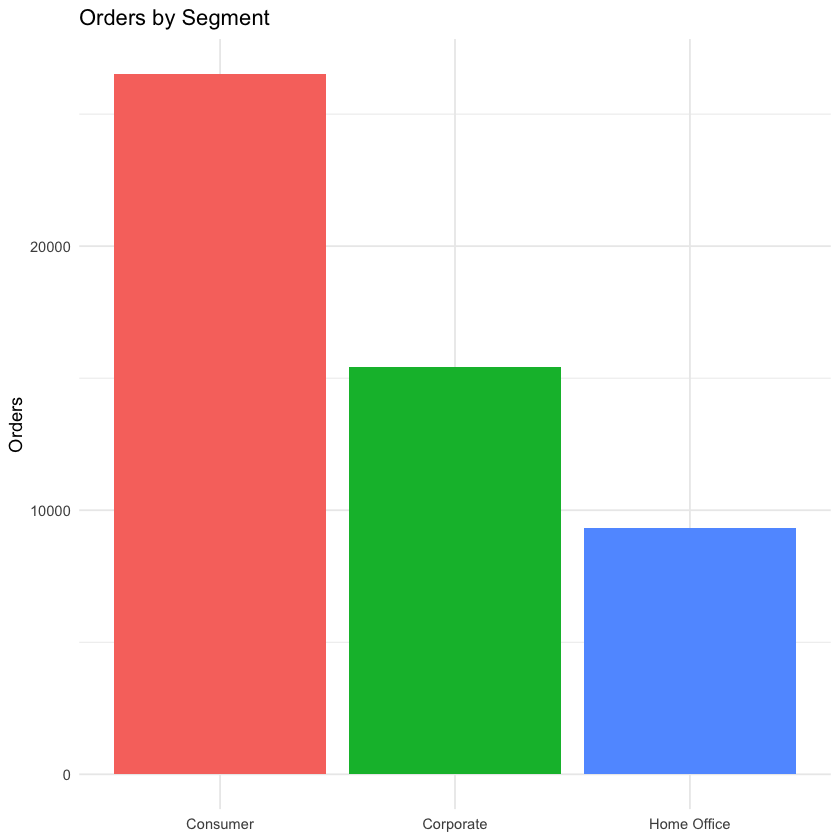

In [6]:
orders |> 
    count(segment, name = "orders") |> 
    ggplot(aes(segment, orders, fill = segment)) + 
    geom_col() + 
    labs(
        title = "Orders by Segment", 
        x = NULL, 
        y = "Orders"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

# Segment Performance Profile

### Sales vs Profit by Segment (scatter)

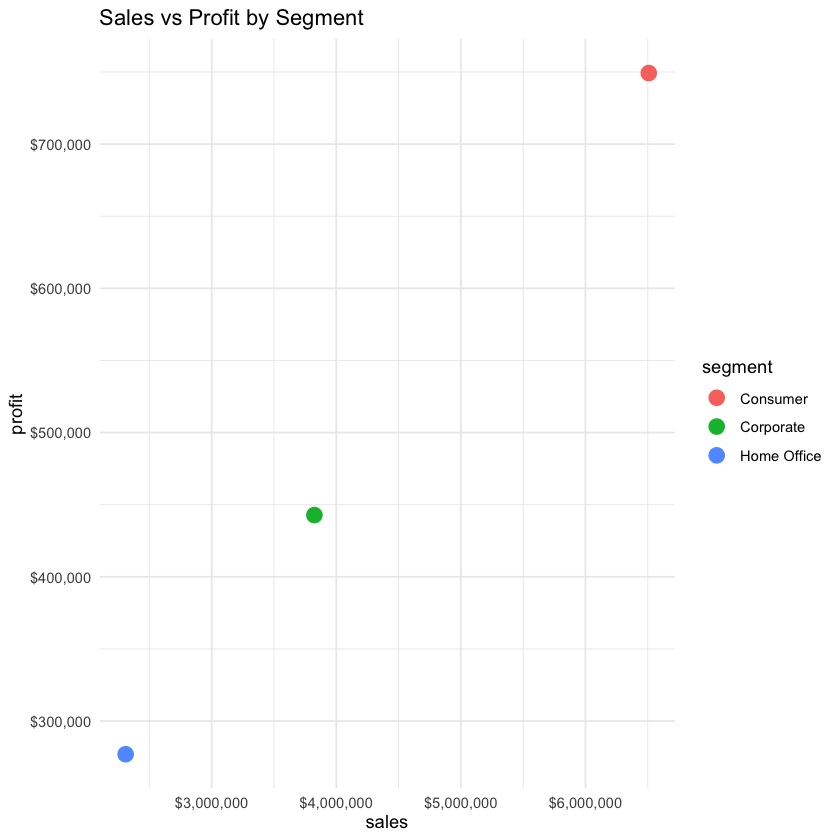

In [ ]:
orders |> 
    group_by(segment) |> 
    summarise(sales = sum(sales), profit = sum(profit)) |> 
    ggplot(aes(sales, profit, color = segment)) + 
    geom_point(size = 4) + 
    scale_x_continuous(labels = scales::dollar_format()) + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(title = "Sales vs Profit by Segment") + 
    theme_minimal()

### Orders vs Sales by Segment (scatter)

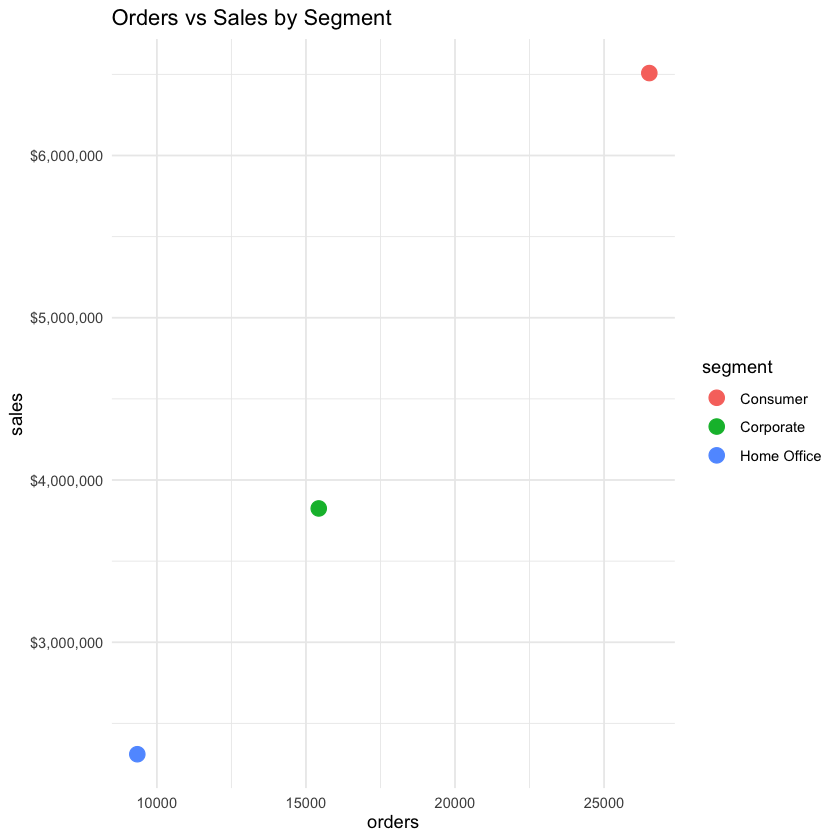

In [7]:
orders |> 
    group_by(segment) |> 
    summarise(sales = sum(sales), orders = n()) |> 
    ggplot(aes(orders, sales, color = segment)) + 
    geom_point(size = 4) + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(title = "Orders vs Sales by Segment") + 
    theme_minimal()

### Average Order Value (AOV) by Segment

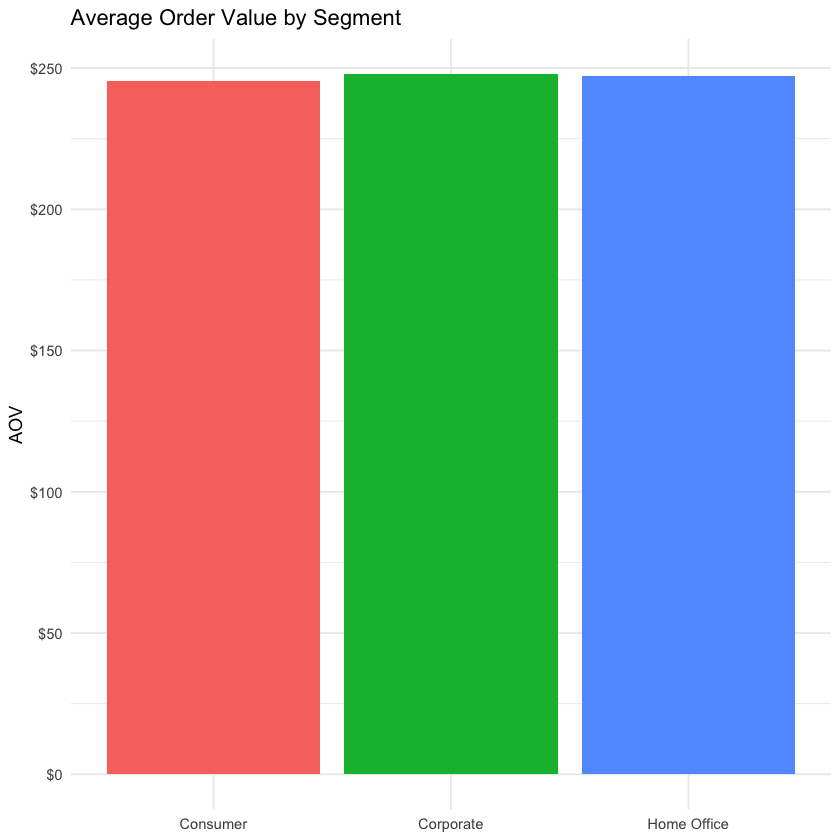

In [8]:
orders |> 
    group_by(segment) |> 
    summarise(aov = sum(sales) / n()) |> 
    ggplot(aes(segment, aov, fill = segment)) + 
    geom_col() + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Average Order Value by Segment", 
        x = NULL, 
        y = "AOV"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

# Product mix within Segments

### Category share of segment sales

`summarise()` has grouped output by 'segment'. You can override using the
`.groups` argument.


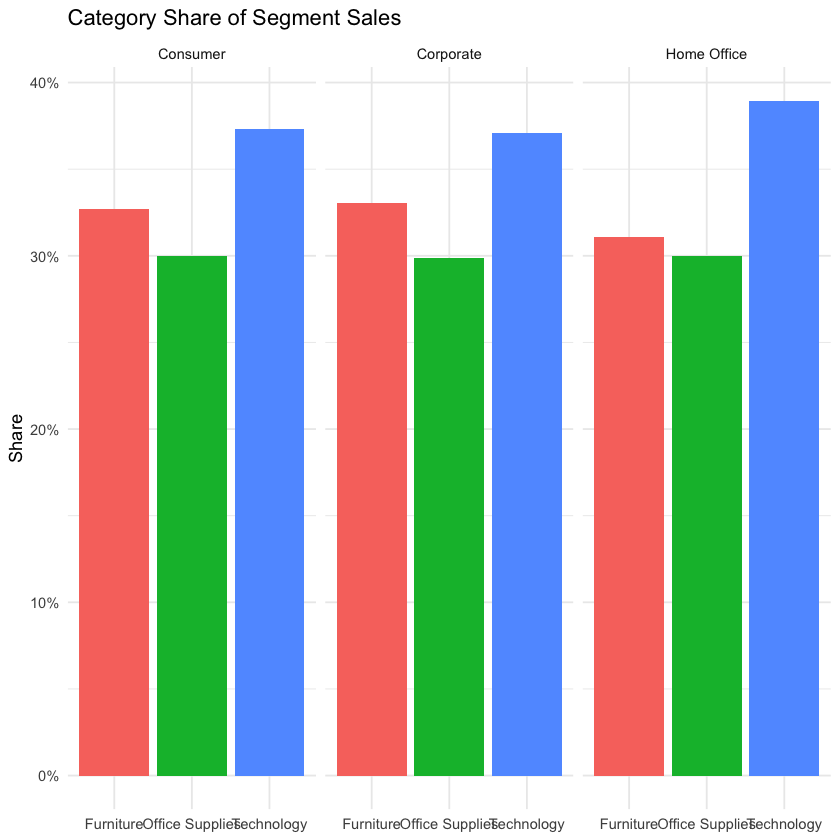

In [9]:
orders |> 
    group_by(segment, category) |> 
    summarise(sales = sum(sales)) |> 
    group_by(segment) |> 
    mutate(share = sales / sum(sales)) |> 
    ggplot(aes(category, share, fill = category)) + 
    geom_col() + 
    facet_wrap(~segment) + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Category Share of Segment Sales", 
        x = NULL, 
        y = "Share"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

### Sub-category share of segment sales

`summarise()` has grouped output by 'segment'. You can override using the
`.groups` argument.


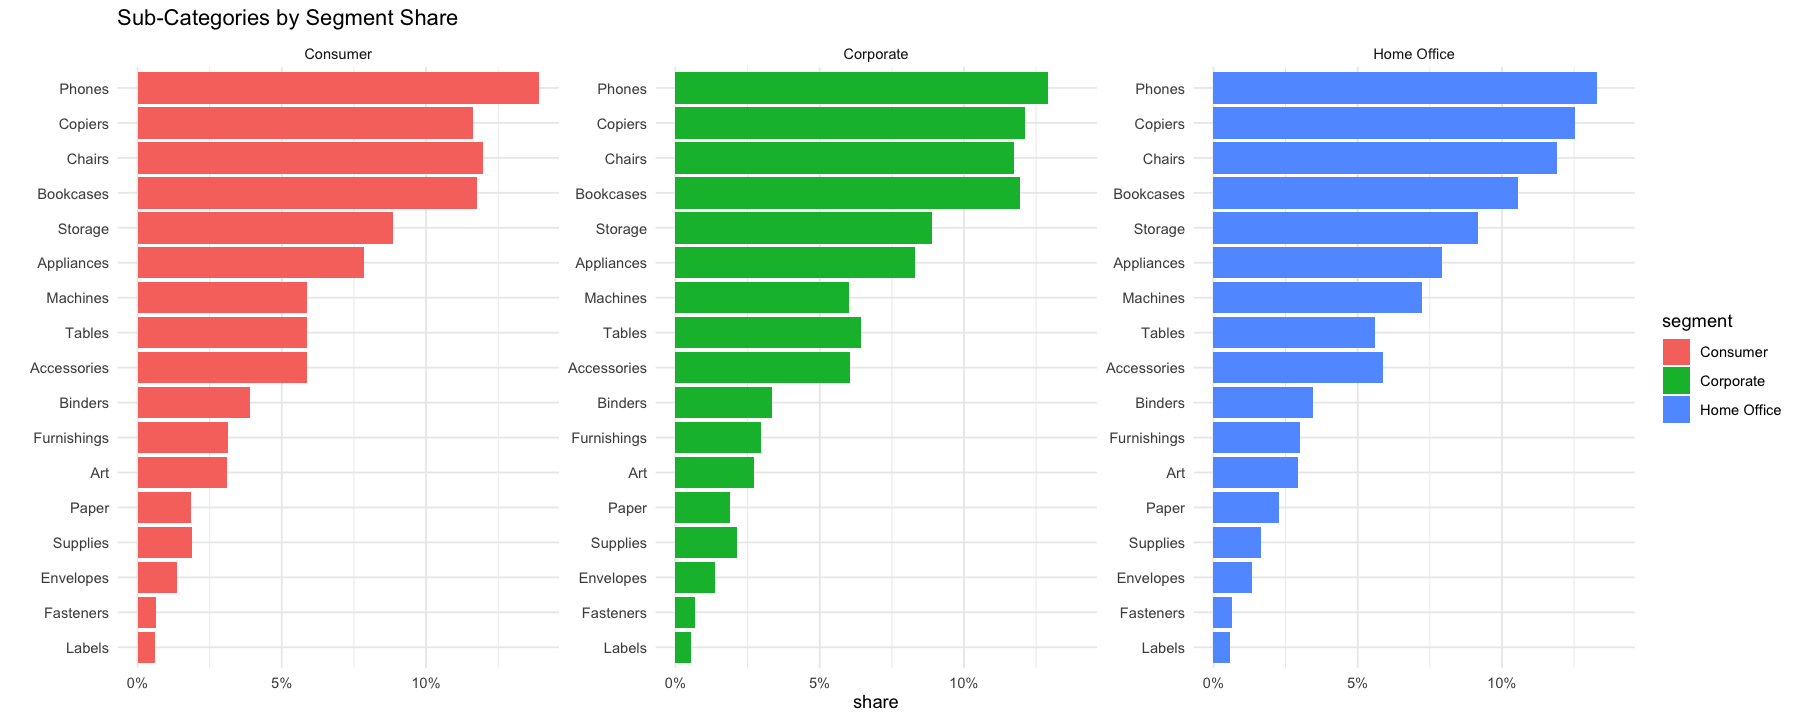

In [12]:
options(repr.plot.width = 15, repr.plot.height = 6)

orders |> 
    group_by(segment, sub_category) |> 
    summarise(sales = sum(sales)) |> 
    group_by(segment) |> 
    mutate(share = sales / sum(sales)) |> 
    ggplot(aes(reorder(sub_category, share), share, fill = segment)) + 
    geom_col() + 
    coord_flip() + 
    facet_wrap(~segment, scales = "free_y") + 
    scale_x_discrete("") + 
    scale_y_continuous(labels = scales::percent) + 
    labs(title = "Sub-Categories by Segment Share") + 
    theme_minimal()

### Top/bottom N products by sales (per segment)

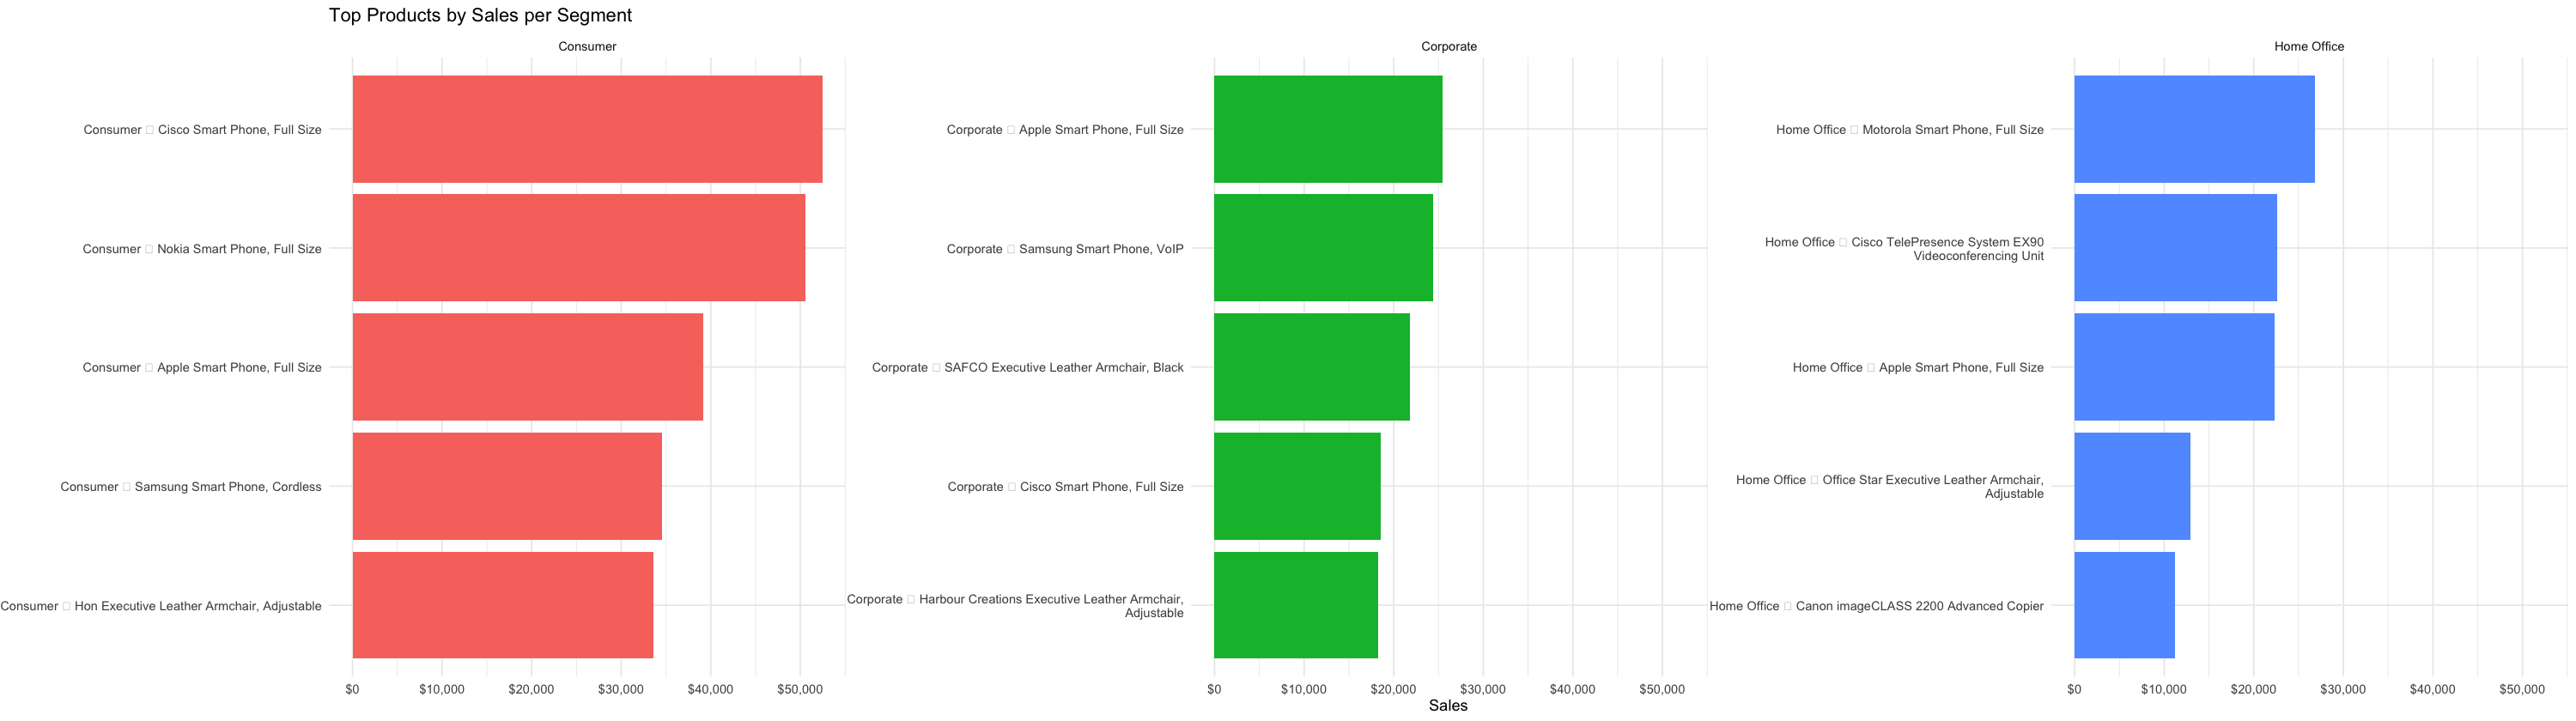

In [13]:
N <- 5

top_products <- orders |> 
    group_by(segment, product_name) |> 
    summarise(sales = sum(sales), .groups = "drop") |> 
    group_by(segment) |> 
    slice_max(sales, n = N, with_ties = FALSE) |> 
    ungroup() |> 
    mutate(product_in_segment = paste0(segment, "  ", product_name))

options(repr.plot.width = 25, repr.plot.height = 7)

ggplot(top_products, aes(reorder(product_in_segment, sales), sales, fill = segment)) + 
    geom_col(show.legend = FALSE) + 
    coord_flip() + 
    facet_wrap(~segment, scales = "free_y") + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Top Products by Sales per Segment", 
        x = NULL, 
        y = "Sales"
    ) + 
    scale_x_discrete(labels = function(x) stringr::str_wrap(x, width = 60)) + 
    theme_minimal()

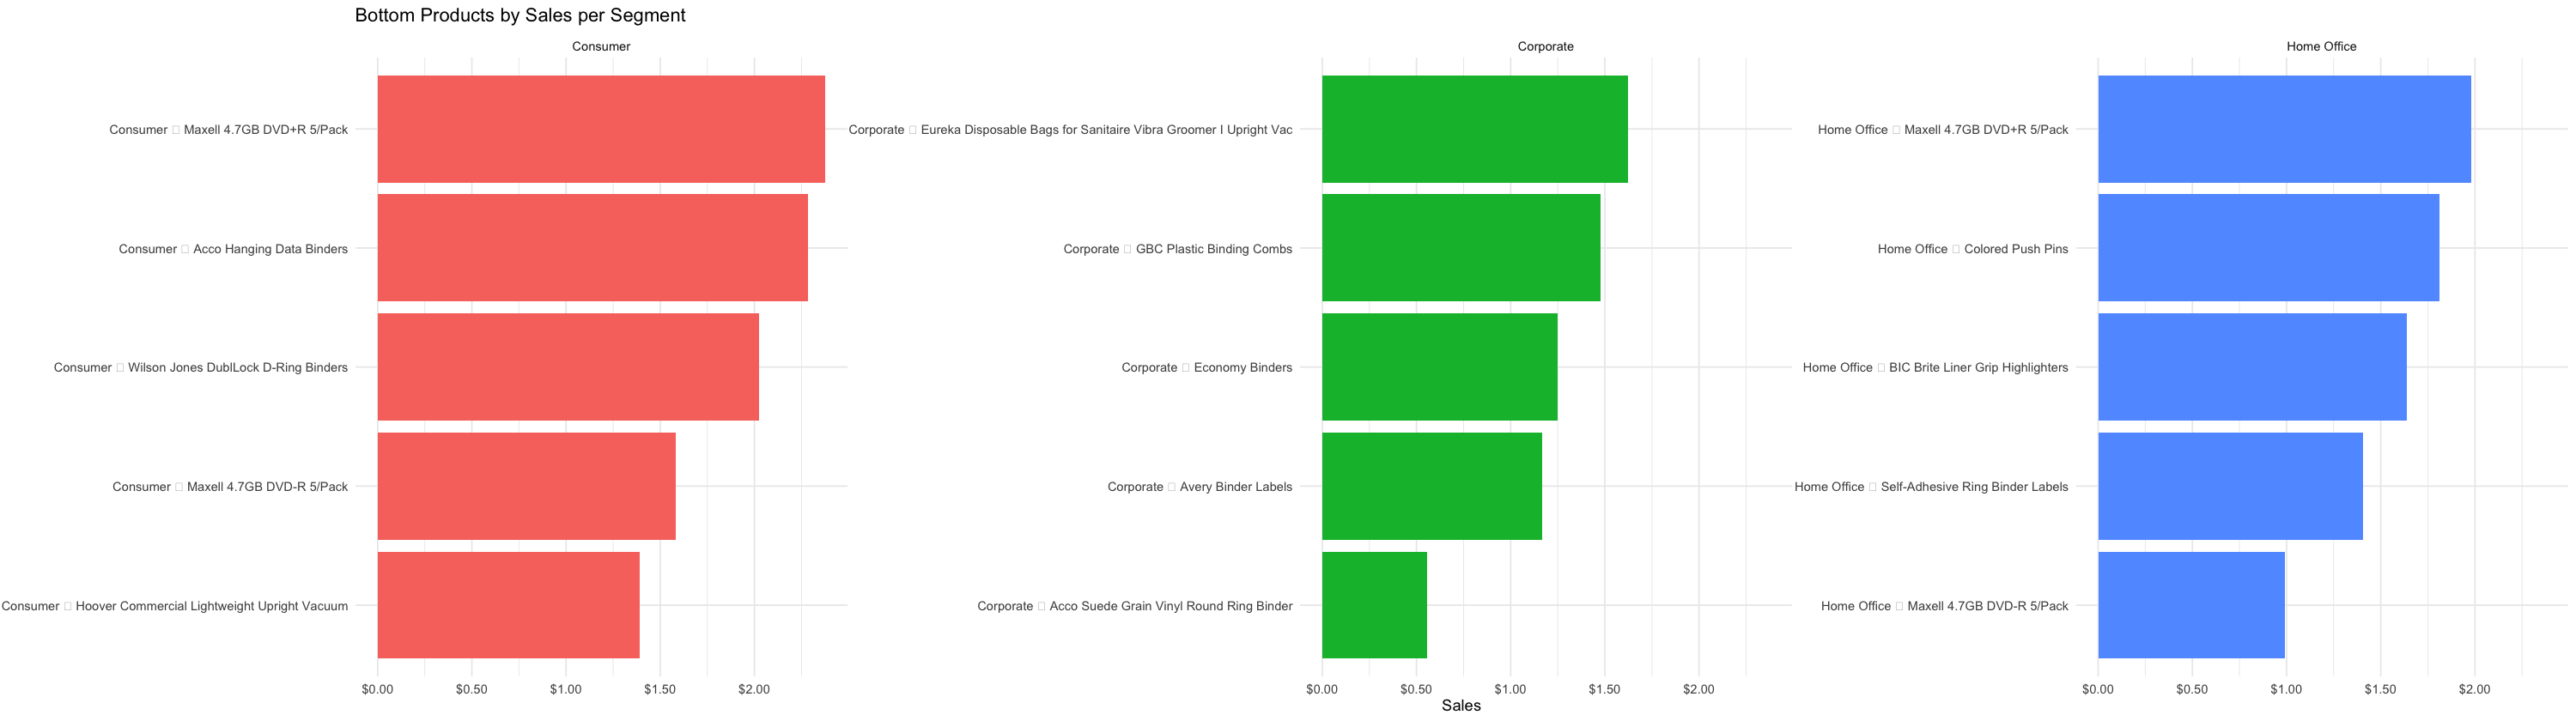

In [14]:
bottom_products <- orders |> 
    group_by(segment, product_name) |> 
    summarise(sales = sum(sales), .groups = "drop") |> 
    group_by(segment) |> 
    slice_min(sales, n = N, with_ties = FALSE) |> 
    ungroup() |> 
    mutate(product_in_segment = paste0(segment, "  ", product_name))

options(repr.plot.width = 25, repr.plot.height = 7)

ggplot(bottom_products, aes(reorder(product_in_segment, sales), sales, fill = segment)) + 
    geom_col(show.legend = FALSE) + 
    coord_flip() + 
    facet_wrap(~segment, scales = "free_y") + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Bottom Products by Sales per Segment", 
        x = NULL, 
        y = "Sales"
    ) + 
    theme_minimal()

# Profitability & Risk by Segment

### Profit margin distribution by segment (box/violin)

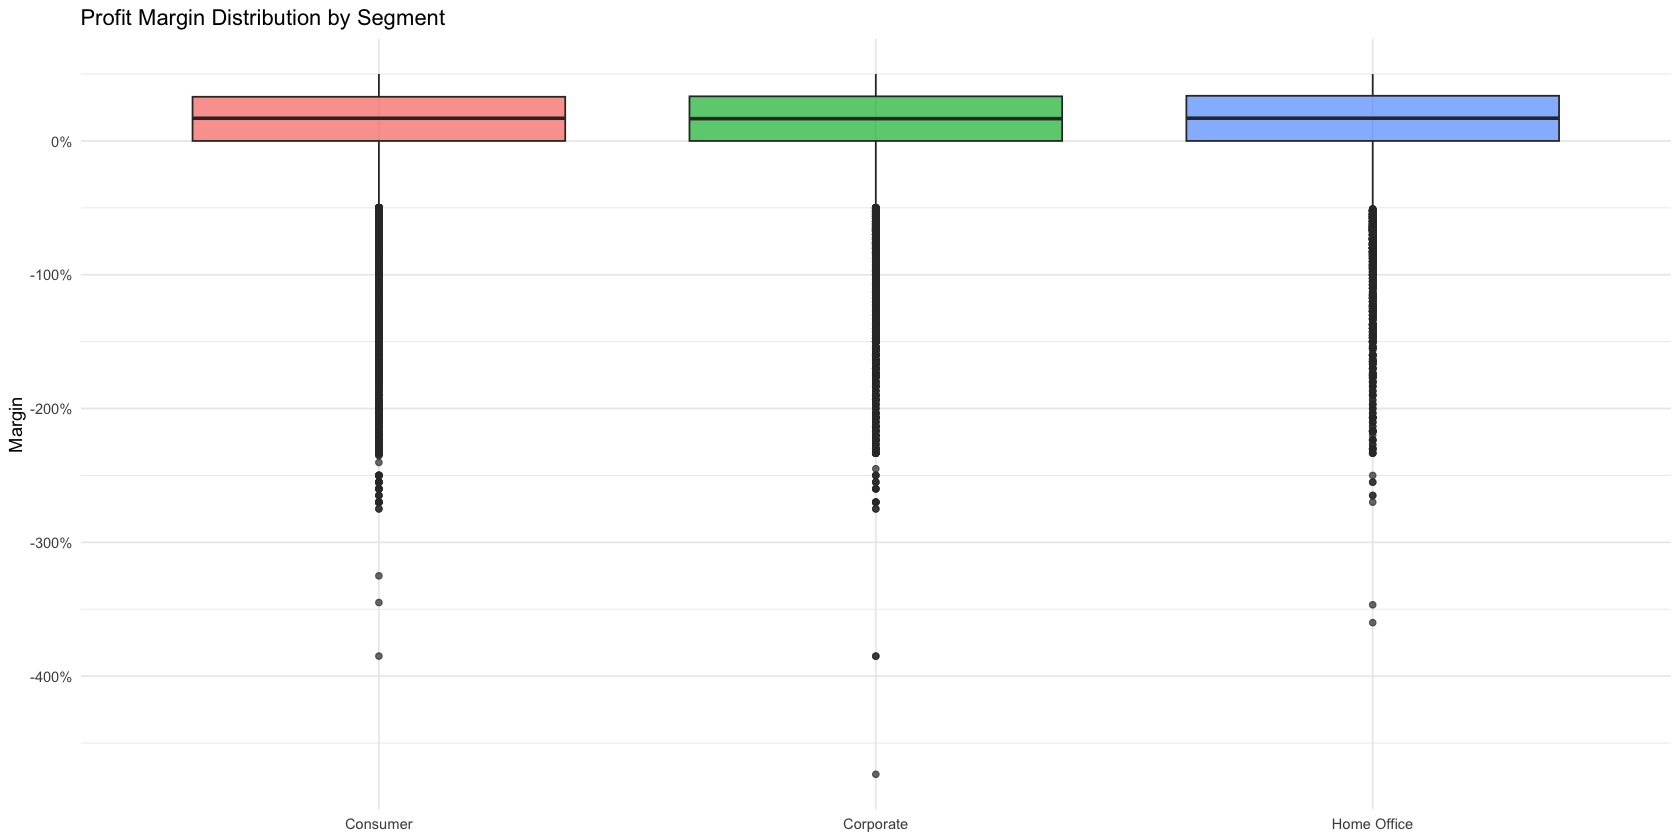

In [18]:
options(repr.plot.width = 14, repr.plot.height = 7)

orders |> 
    mutate(margin = profit / sales) |> 
    ggplot(aes(segment, margin, fill = segment)) + 
    geom_boxplot(alpha = 0.7) + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Profit Margin Distribution by Segment", 
        x = NULL, 
        y = "Margin"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

### Discount vs Profit by segment (faceted scatter)

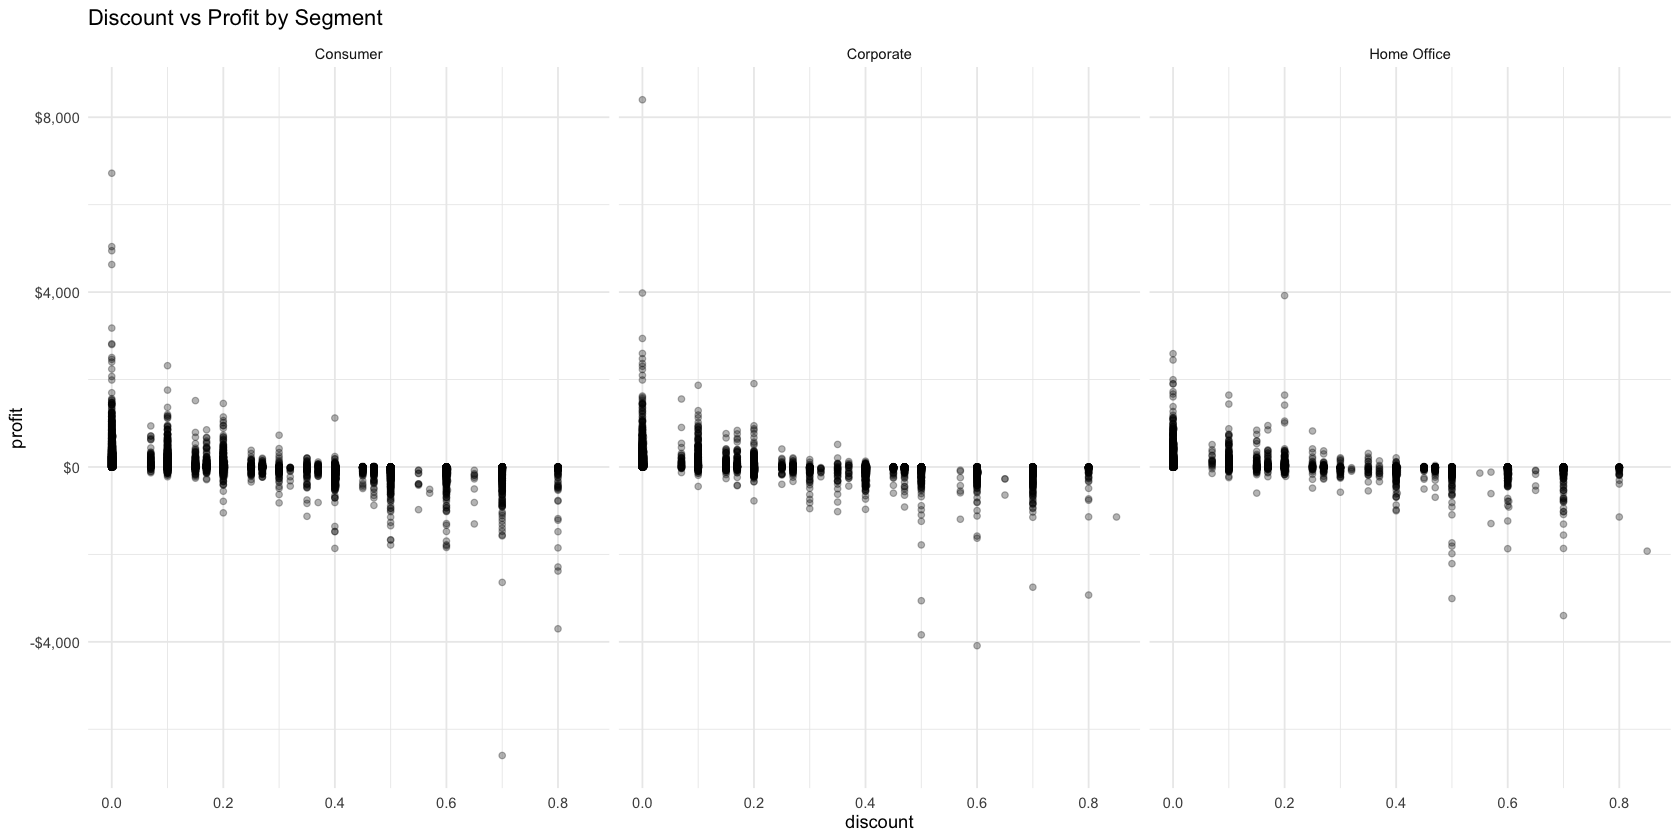

In [19]:
orders |> 
    ggplot(aes(discount, profit)) + 
    geom_point(alpha = 0.3) + 
    facet_wrap(~segment) + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Discount vs Profit by Segment"
    ) + 
    theme_minimal()

### Return rate by segment

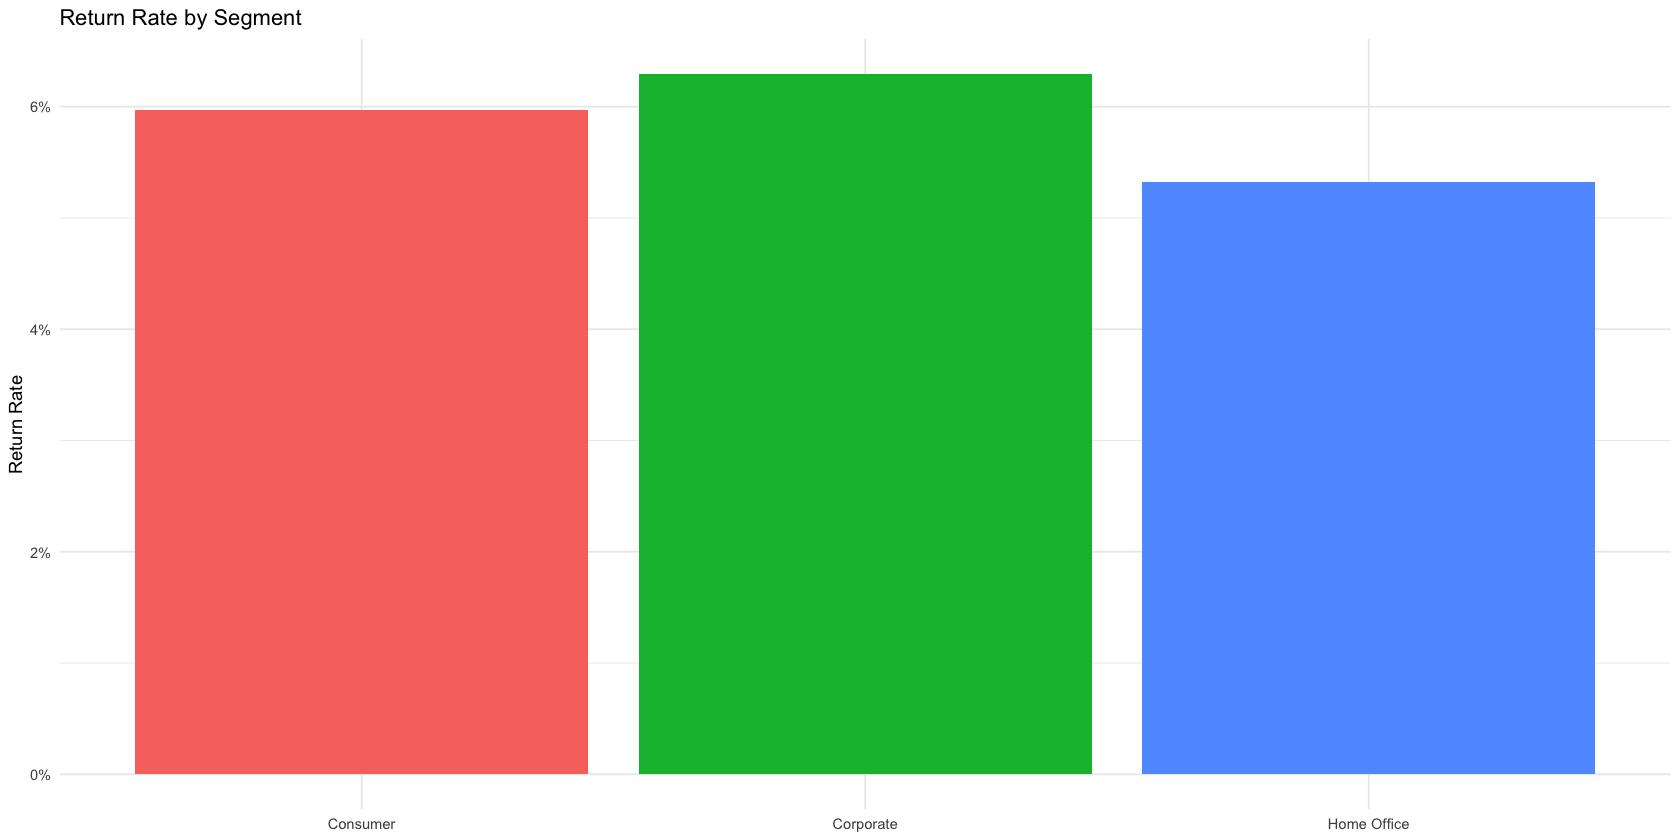

In [20]:
orders_with_returns <- orders |> 
    left_join(
        returns |> 
            distinct(order_id) |> 
            mutate(returned = 1),
        by = "order_id"
    ) |> 
    mutate(returned = if_else(is.na(returned), 0, returned))

orders_with_returns |> 
    group_by(segment) |> 
    summarise(return_rate = mean(returned)) |> 
    ggplot(aes(segment, return_rate, fill = segment)) + 
    geom_col() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Return Rate by Segment", 
        x = NULL, 
        y = "Return Rate"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

# Concentration & Dependency (Segment)

### Top X% of products vs segment sales contribution

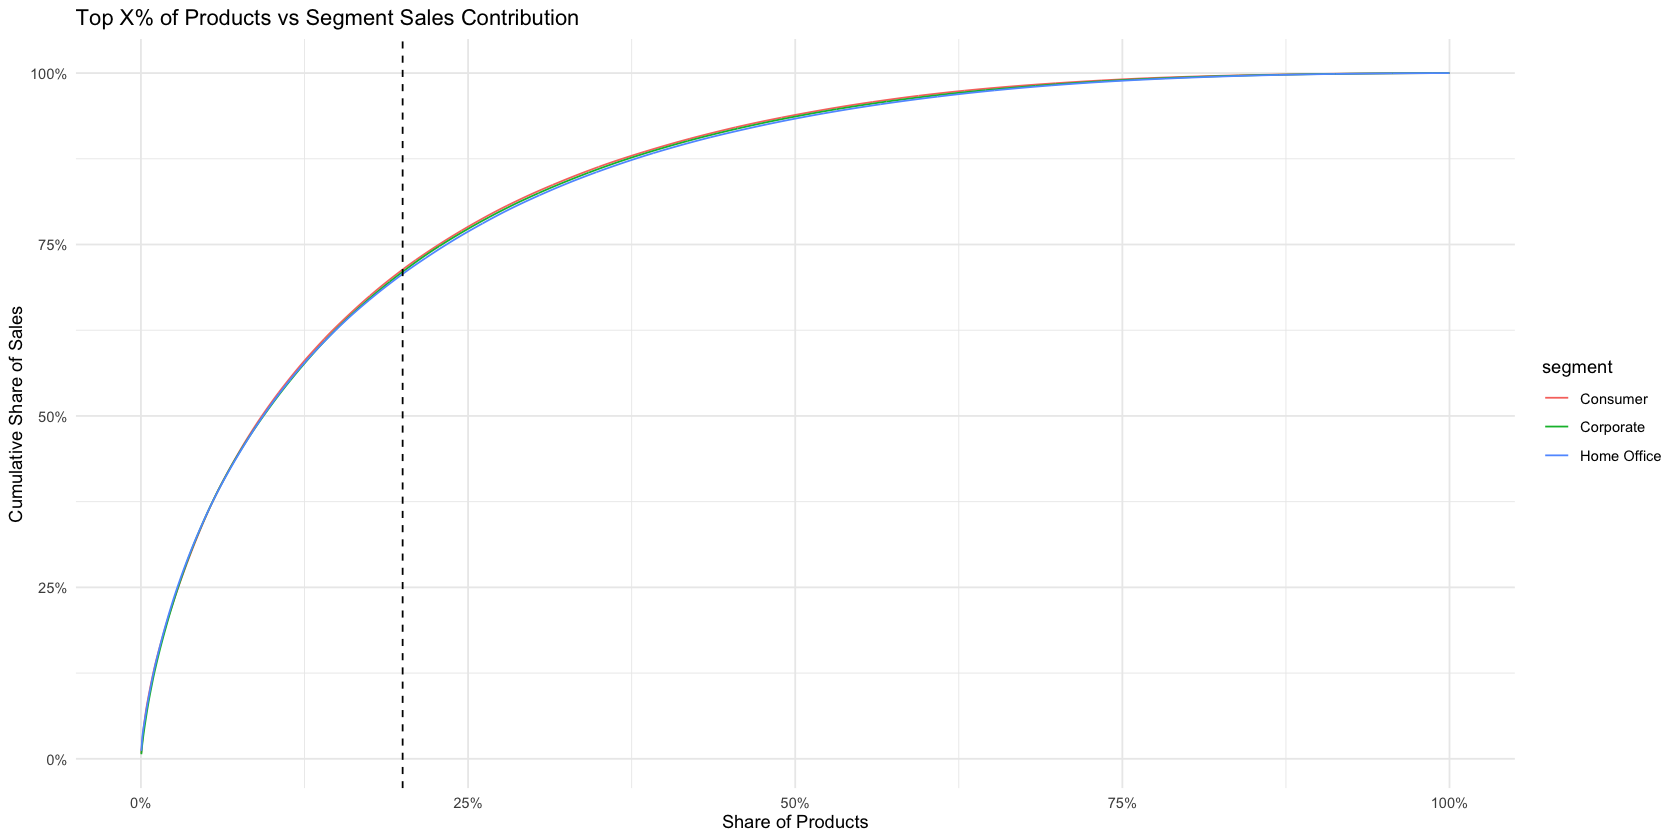

In [21]:
X <- 0.2

segment_product_sales <- orders |> 
    group_by(segment, product_name) |> 
    summarise(sales = sum(sales), .groups = "drop") |> 
    group_by(segment) |> 
    arrange(desc(sales)) |> 
    mutate(
        cum_sales = cumsum(sales),
        total_sales = sum(sales),
        cum_share = cum_sales / total_sales,
        product_rank = row_number(),
        product_pct = product_rank / n()
    )

segment_product_sales |> 
    ggplot(aes(product_pct, cum_share, color = segment)) + 
    geom_line() + 
    geom_vline(xintercept = X, linetype = "dashed") + 
    scale_y_continuous(labels = scales::percent) + 
    scale_x_continuous(labels = scales::percent) + 
    labs(
        title = "Top X% of Products vs Segment Sales Contribution",
        x = "Share of Products",
        y = "Cumulative Share of Sales"
    ) + 
    theme_minimal()

### Top X% of customers vs segment sales contribution 

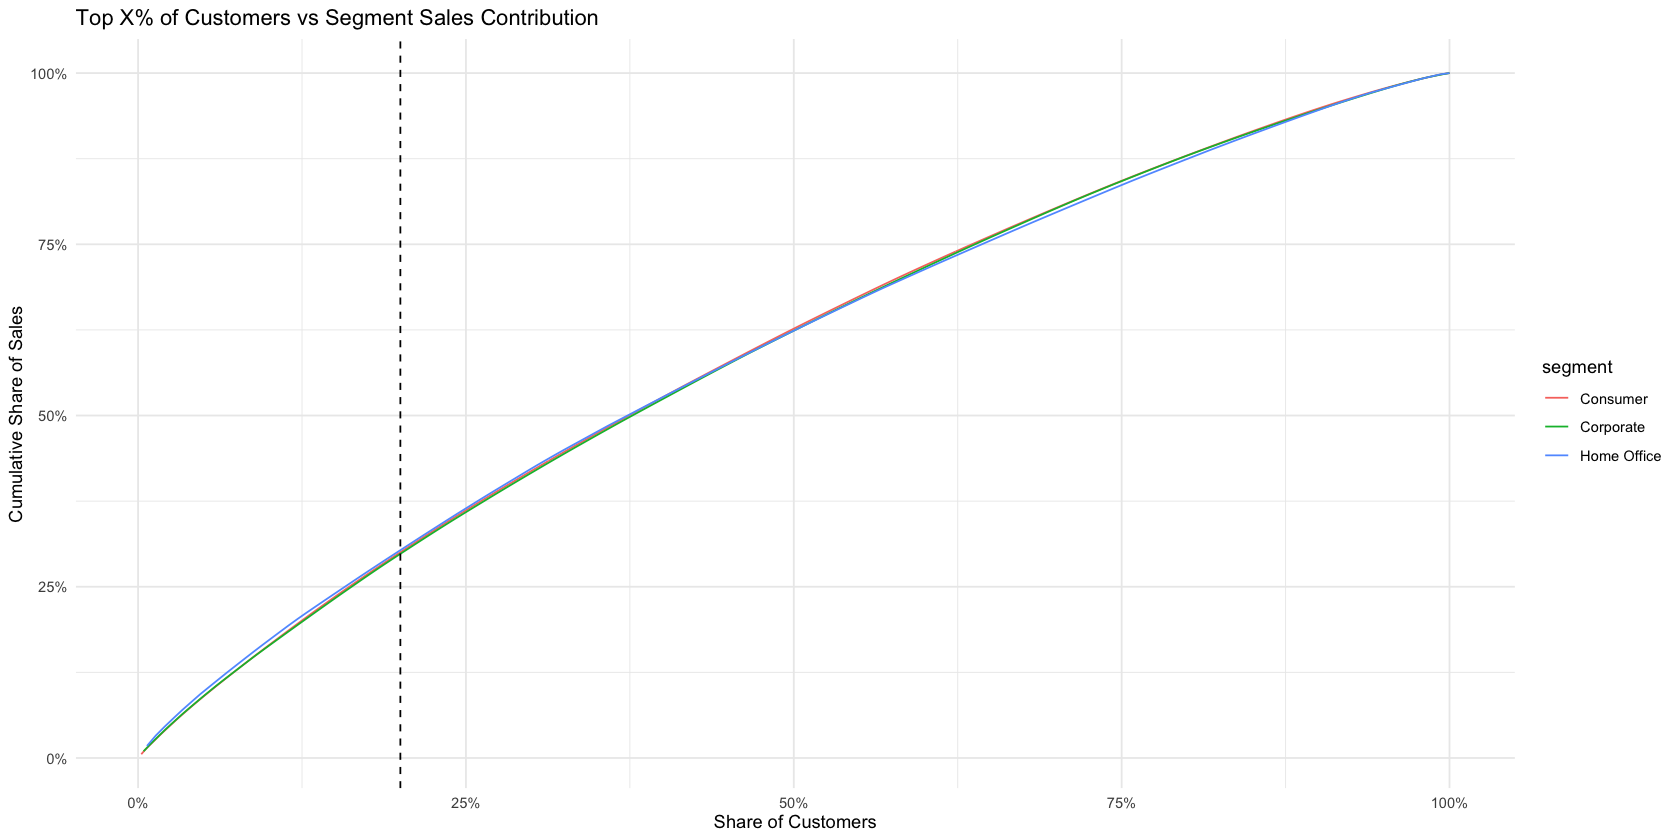

In [22]:
segment_customer_sales <- orders |> 
    group_by(segment, customer_name) |> 
    summarise(sales = sum(sales), .groups = "drop") |> 
    group_by(segment) |> 
    arrange(desc(sales)) |> 
    mutate(
        cum_sales = cumsum(sales),
        total_sales = sum(sales),
        cum_share = cum_sales / total_sales,
        customer_pct = row_number() / n()
    )

segment_customer_sales |> 
    ggplot(aes(customer_pct, cum_share, color = segment)) + 
    geom_line() + 
    geom_vline(xintercept = X, linetype = "dashed") + 
    scale_y_continuous(labels = scales::percent) + 
    scale_x_continuous(labels = scales::percent) + 
    labs(
        title = "Top X% of Customers vs Segment Sales Contribution",
        x = "Share of Customers",
        y = "Cumulative Share of Sales"
    ) + 
    theme_minimal()